<h1>SEM Image Quality Assessment & Tool-to-Tool Matching</h1>

# Introduction

Modern CD-SEM workflows depend on stable image quality: if focus, stigmation, detector noise, or operating-point drift slip, measurements and SPC dashboards follow them downhill. This notebook demonstrates a compact, practical toolkit for image quality assessment (IQA) and tool-to-tool matching using non-proprietary images. The goal is twofold:

1. Show that the selected metrics are sensitive to the kinds of degradation we actually see on SEM tools, and

2. Show how I troubleshoot and validate a tool—with simple, explainable visuals and numbers.


## What’s inside (at a glance)

- Full-reference metrics (FR):
    Normalized variance focusscore , SSIM (structure similarity) and PSNR to compare a test frame to a clean reference.

- No-reference metrics (NR):
  Laplacian variance (sharpness), FFT high-frequency ratio (fine-detail energy), and CNR (contrast-to-noise) on fixed ROIs.

- Tool-to-tool matching panel:
 overlapping histograms (brightness/contrast/shape) plus summary stats (mean, std, skew, kurtosis) to verify operating-point consistency.

- Synthetic/benchmark inputs:
To avoid proprietary data, examples use [public or synthetic images](https://doi.org/10.1016/j.image.2014.10.009); degradations emulate defocus/blur, stigmation-like anisotropy, shot/read noise, and gain/contrast drift.

- A gold sputtered on carbon substrate images(a.k.a GoC) is probably the first image someone would see a SEM tool is returned from a major vendor work or preventative maintance(PM). To demonstrate **Normalized variance focus score(Normvar)** I used a GoC images available from [public domain](https://upload.wikimedia.org/wikipedia/commons/8/82/Gold_on_Carbon.jpg). This method is usually stable  and coincides with human perception of focus and blurred images. This method was dopted from *[Yu Sun and et al.](https://doi.org/10.1002/jemt.20118)* 

- In almost all cases **BRISQUE**(lower score is better) is not a helpfull method to determine tool performance.

## How to read the results

- Normvar/SSIM/PSNR: overall quality vs reference; higher is better.

- Laplacian variance & FFT ratio: sharpness indicators; both should fall with blur. The FFT ratio helps distinguish “noisy-sharp” from “clean-blurred.”

- Histograms: alignment of means/widths (and similar shapes) indicates comparable detector gain/offset and contrast settings.

## Why these choices

The metrics are intentionally simple, explainable, and fast. They capture the main SEM failure modes without requiring heavy models or opaque tuning. Where helpful, I add visual overlays (SSIM maps, FFT magnitude views) so a reviewer can see where quality diverges—not just a number.


## Citation

## Table of Contents

- [IQA functions](#iqa-functions)
- [Load images](#load-images)
- [Gold on Carbon focus](#gold-on-carbon-image-focus-assesment)
- [Distortion Types](#distortion-types)
    - [Poisson](#poisson-noise)
    - [Stigmation](#stigmation)
- [FFT Sharpness](#fft-sharpness)
- [Histogram](#image-histogram)
- [Conclusion](#conclusion)
- [Acknowledgement](#acknowledgement)

**libraries for the codes below**

In [ ]:
#Install-if-missing, then import 
import numpy as np
import cv2
from tabulate import tabulate
import pandas as pd
import glob, os
from pathlib import Path
import random, math
import matplotlib.pyplot as plt
import skimage.color
from skimage import metrics
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy import fft
import warnings
warnings.filterwarnings('ignore')

## IQA functions

**cell below containes IQA functions**

In [6]:
# 1. Helper function for loading image and covert it to grayscale
def load2gray(image_input):
    """ 
    - Helper function to differentiate between image and image path.
    - convert image to grayscale
    """
    try:
        if isinstance(image_input,(str, Path)):
                path = Path(image_input)
                if path.exists() and path.is_file():
                    image = cv2.imread(str(path),cv2.IMREAD_GRAYSCALE)
                    if image is None:
                        raise ValueError(f"coild not load image from{path}")
                    return image
                else:
                    raise FileNotFoundError(f"File not found:{path}")
        elif isinstance(image_input, np.ndarray) and image_input.ndim in (2,3):
            if image_input.ndim == 2:
                return image_input
            elif image_input.ndim == 3:
                if image_input.shape[:2] == 3:
                    return cv2.cvtColor(image_input, cv2.COLOR_BGR2GRAY)
                elif image_input.shape[2] == 4: # RGBA/BGRA
                    return cv2.cvtColor(image_input, cv2.COLOR_BGRA2GRAY)
                else:
                    raise ValueError(f"Unexpected number of channels: {image_input.shape[2]}")
            else:
                raise ValueError(f"Unexpected array dimensions: {image_input.ndim}")
        else:
            raise TypeError(f"Unsupported input type: {type(image_input)}")      
    except Exception as e:
        print(f"Error in load2gray: {e}")
        return None

# 2. Normalized variance focus score assesment 
def NormvarFocus(image_input):
    """
    Calculate normalized variance focus measure for an image.
    """
    image = load2gray(image_input)
    try:
    # path detection
        mean, std = cv2.meanStdDev(image)
        mean_val = mean[0,0]
        std_val = std[0,0]
        return float(std_val**2/mean_val) if mean_val !=0 else np.nan
    except Exception as e:
        print(e)
# 3. BRISQUE image quality assesment
def BrisqueScore(image_input, model_path = None, range_path = None):
    """
    This function uses opencv-contrib-python package
    --- Generates BRISQUE score.lower score is better 
    --- image_path : path to the image file.
    --- model_path: defaults to the path provided when None
    --- range_path: defaults to the path provided when None
    """
    try:
        img = load2gray(image_input)
        # path to BRISQUE model files
        if model_path is None:
            model_path = Path('opencv_models/brisque_model_live.yml')
        if range_path is None:
            range_path = Path('opencv_models/brisque_range_live.yml')
        # generate BRISQUE score.
        score = cv2.quality.QualityBRISQUE_compute(img,str(model_path),str(range_path))[0]
        return float(score)
    except Exception as e:
        print(e)

# Custom distortion function for : stigmation and poission noise

# 4. apply sem like stigmation noise
def apply_stigmation(image, ksize_x=9, ksize_y=3, angle=0):
    """
    Simpler stigmation using rectangular kernels and rotation
    """
    # Create rectangular kernel for directional blur
    kernel = np.ones((ksize_y, ksize_x), np.float32) / (ksize_x * ksize_y)
    
    # Rotate kernel to desired angle
    M = cv2.getRotationMatrix2D((ksize_x//2, ksize_y//2), angle, 1)
    kernel_rotated = cv2.warpAffine(kernel, M, (ksize_x, ksize_y))
    
    # Apply blur and clip
    result = cv2.filter2D(image.astype(np.float32), -1, kernel_rotated)
    return np.clip(result, 0, 255).astype(np.uint8)
# 5. add simple Poission noise 
def add_poisson(img, peak=20):
    """ 
    -- adding poision noise to the image . This simulates beam jitters or .
    """
    img = load2gray(img)
    lam = np.clip(img, 0,1.0)*peak
    noisy = np.random.poisson(lam).astype(np.float32) / max(float(peak),1e-6)
    return np.clip(noisy, 0,1.0)

# 6.  Add a mixture of poission and gaussian noise
def add_poisson_gaussian(img_float_0_1, peak=20, read_std=0.002, gain=1.0, offset=0.0):
    """ 
    Poisson-Gaussian : This simulates real SEM image frames as close as possible.
    -- Read/Electronic noise a bit mixture of roughly Gaussian(small amount) and noise arising from 
    electron counts(Shot) as Poission with some offset/gain.
    """
    # Linear response with gain/offset
    x = np.clip(gain * img_float_0_1 + offset, 0, 1)
    # Poisson shot noise (counts)
    lam = x * float(peak)
    y_counts = np.random.poisson(lam).astype(np.float32)
    # Add read noise in "normalized" space
    y = y_counts / float(peak) + np.random.normal(0.0, read_std, x.shape).astype(np.float32)
    return np.clip(y, 0, 1)
# 7. Function to calcualte quality metrics: Normvarfocus, SSIM, PSNR, BRISQUE 
def calculate_all_metrics(original, processed):
    """
    Calculate multiple image quality metrics for comparison.
    
    Parameters:
    original: Original image
    processed: Processed image to evaluate
    
    Returns:
    Dictionary containing all metrics
    """
    # Ensure images are grayscale and have the same dimensions
    if len(original.shape) > 2:
        original = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    if len(processed.shape) > 2:
        processed = cv2.cvtColor(processed, cv2.COLOR_RGB2GRAY)
    
    # Resize processed image to match original dimensions if needed
    if original.shape != processed.shape:
        processed = cv2.resize(processed, (original.shape[1], original.shape[0]))
    
    # Calculate metrics
    metrics_dict = {}
    
    # Normalized Variance Focus Score
    metrics_dict['nv_original'] = NormvarFocus(original)
    metrics_dict['nv_processed'] = NormvarFocus(processed)
    metrics_dict['nv_ratio'] = metrics_dict['nv_processed'] / metrics_dict['nv_original'] if metrics_dict['nv_original'] != 0 else 0
    
    # PSNR
    try:
        metrics_dict['psnr'] = metrics.peak_signal_noise_ratio(original, processed)
    except:
        metrics_dict['psnr'] = 0
    
    # SSIM
    try:
        metrics_dict['ssim'] = metrics.structural_similarity(original, processed)
    except:
        metrics_dict['ssim'] = 0
    # BRISQUE
    try:
        metrics_dict["BRISQUE_orig"] = BrisqueScore(original,model_path=None,range_path=None)
        metrics_dict["BRISQUE_processed"] = BrisqueScore(processed, model_path=None, range_path=None)
    except Exception as e:
        return print(e)
    
    try: 
        orig_score, noisy_score, sharpness_ratio = compute_sharpness_lap(original,processed)
        metrics_dict["laplacian_orig"] = orig_score
        metrics_dict["laplacian_noisy"] = noisy_score
        metrics_dict["laplacian_sharpness_ratio"] = sharpness_ratio
    except Exception as e:
        print(e)    
    return metrics_dict
# 8. create a demo for GoC image focus score
def create_focus_assessment_demo(original_image_path):
    """
    Create a comprehensive demo of focus assessment techniques for SEM images.
    """
    # Load and prepare image
    original = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    assert original is not None, "Image not found"
    
    # Store original dimensions for resizing later
    orig_h, orig_w = original.shape
    
    # Create different versions of the image
    images = {
        'Original': original,
        'Blurred (σ=1)': cv2.GaussianBlur(original, (5, 5), 1),
        'Blurred (σ=2)': cv2.GaussianBlur(original, (9, 9), 2),
        'Brightness +20%': np.clip(original * 1.2, 0, 255).astype(np.uint8),
        'Contrast +30%': np.clip(original * 0.7 + 0.3 * original.mean(), 0, 255).astype(np.uint8),
    }
    
    # Add rotated versions (we'll handle these specially for display)
    rotated_90 = cv2.rotate(original, cv2.ROTATE_90_CLOCKWISE)
    rotated_180 = cv2.rotate(original, cv2.ROTATE_180)
    rotated_270 = cv2.rotate(original, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    # Store rotated images with their original dimensions
    rotated_images = {
        'Rotated 90°': rotated_90,
        'Rotated 180°': rotated_180,
        'Rotated 270°': rotated_270
    }
    
    # Calculate metrics for each image
    results = {}
    for name, img in images.items():
        results[name] = calculate_all_metrics(original, img)
    
    # Calculate metrics for rotated images (using resized versions)
    for name, img in rotated_images.items():
        # Resize rotated image to match original dimensions for metric calculation
        resized_img = cv2.resize(img, (orig_w, orig_h))
        results[name] = calculate_all_metrics(original, resized_img)
    
    # Create visualization
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.ravel()
    
    # Display regular images
    regular_names = list(images.keys())
    for i, name in enumerate(regular_names):
        axes[i].imshow(images[name], cmap='gray')
        axes[i].set_title(f"{name}\nNV Ratio: {results[name]['nv_ratio']:.3f}\nSSIM: {results[name]['ssim']:.3f}")
        axes[i].axis('off')
    
    # Display rotated images
    for i, name in enumerate(rotated_images.keys()):
        axes[i+5].imshow(rotated_images[name], cmap='gray')
        axes[i+5].set_title(f"{name}\nNV Ratio: {results[name]['nv_ratio']:.3f}\nSSIM: {results[name]['ssim']:.3f}")
        axes[i+5].axis('off')
    
    # Hide unused subplots
    for i in range(len(regular_names) + len(rotated_images), 9):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Create metric comparison table
    print("Metric Comparison Across Image Variations")
    print("=" * 90)
    print(f"{'Image Variation':<20} {'NV Ratio':<10} {'PSNR':<10} {'SSIM':<10}")
    print("-" * 90)
    
    for name in list(images.keys()) + list(rotated_images.keys()):
        print(f"{name:<20} {results[name]['nv_ratio']:<10.3f} {results[name]['psnr']:<10.3f} {results[name]['ssim']:<10.3f}")
    
    return results
# 9. calculate sharpness using FFT method
def fft_sharpness(image, low_cutoff=0.1, high_cutoff=0.4):
    """
    Advanced FFT sharpness with configurable frequency bands.
    
    Parameters:
    - low_cutoff: Lower frequency bound (0-0.5)
    - high_cutoff: Upper frequency bound (0-0.5)
    
    Returns:
    - sharpness_score: Higher values indicate sharper images
    - spectrum_visual: Magnitude spectrum for visualization
    """
    # FFT computation
    image = load2gray(image)
    f_transform = fft.fft2(image.astype(float))
    f_shift = fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shift)
    
    # Create frequency band mask
    h, w = image.shape
    center_y, center_x = h // 2, w // 2
    max_radius = min(center_x, center_y)
    
    y, x = np.ogrid[:h, :w]
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    # Normalize distance to frequency (0 to 0.5)
    normalized_freq = distance / (2 * max_radius)
    
    # Select mid-to-high frequency band
    freq_mask = (normalized_freq >= low_cutoff) & (normalized_freq <= high_cutoff)
    
    # Calculate sharpness as mean magnitude in selected band
    if np.any(freq_mask):
        sharpness_score = np.mean(magnitude_spectrum[freq_mask])
    else:
        sharpness_score = 0
    
    return sharpness_score, magnitude_spectrum

# 10. Sharpness (Variance of Laplacian)
def compute_sharpness_lap(original,noisy):

    # Ensure images are loaded and grayscale
    #orig_gray = load2gray(original)
    #noisy_gray = load2gray(noisy)
    # Calculate Laplacian variances
    orig_score = cv2.Laplacian(original, cv2.CV_64F).var()
    noisy_score = cv2.Laplacian(noisy, cv2.CV_64F).var()
    # Calculate ratio (avoid division by zero)
    if orig_score > 1e-10:
        sharpness_ratio = noisy_score / orig_score
    else:
        sharpness_ratio = 0
    return orig_score, noisy_score, sharpness_ratio

# 11. helper function to compare FFT sharpness
def fft_sharpness_comparative(reference_image, test_image):
    """
    Compare FFT sharpness between reference and test images.
    Returns ratio and absolute scores.
    - magnitude for plotting 
    """
    # Calculate sharpness for both images
    ref_sharpness, ref_magnitude = fft_sharpness(reference_image)
    test_sharpness, test_magnitude = fft_sharpness(test_image)
    
    # Avoid division by zero
    if ref_sharpness < 1e-10:
        sharpness_ratio = 0
    else:
        sharpness_ratio = test_sharpness / ref_sharpness
    
    results = {
        'reference_sharpness': ref_sharpness,
        'ref_mag': ref_magnitude,
        'test_sharpness': test_sharpness,
        'test_mag': test_magnitude,
        'sharpness_ratio': sharpness_ratio,
        'sharpness_difference': test_sharpness - ref_sharpness
    }
    
    return results
# 11. generate image histogram and extract metrics 
def compare_histograms(ref_img, distorted_img, plot_histograms=False):
    """
    Compare histograms for tool-to-tool matching analysis.
    
    Parameters:
    - ref_img: Reference image (tool 1)
    - distorted_img: Test image (tool 2) 
    - plot_histograms: Whether to display histogram plots
    
    Returns:
    - Dictionary with comprehensive comparison metrics
    """
    img1 = load2gray(ref_img)
    img2 = load2gray(distorted_img)
    if img1 is None or img2 is None:
        raise ValueError("Could not load one or both images")
    # Calculate histogram
    hist1 = cv2.calcHist([img1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([img2], [0], None, [256], [0, 256])
    # Normalize histograms 
    cv2.normalize(hist1, hist1, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist2, hist2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    #multiple histogram comparision methods
    
    corr_score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    corr_score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    chi_square = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    hellinger = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)
    intersect = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)

    # Basic statistics
    ref_mean, ref_std = cv2.meanStdDev(img1)
    dis_mean, dis_std = cv2.meanStdDev(img2)
    # Additional tool-matching metrics

    brightness_diff = abs(float(ref_mean - dis_mean))
    contrast_ratio = float(dis_std / ref_std) if ref_std > 0 else 0
    dynamic_range_ref = img1.max() - img1.min()
    dynamic_range_dis = img2.max() - img2.min()
    # Tool matching assessment
    if corr_score > 0.95 and brightness_diff < 10 and 0.9 < contrast_ratio < 1.1:
        match_quality = "Excellent"
    elif corr_score > 0.85 and brightness_diff < 20 and 0.8 < contrast_ratio < 1.2:
        match_quality = "Good" 
    elif corr_score > 0.7 and brightness_diff < 30:
        match_quality = "Fair"
    else:
        match_quality = "Poor"

    hist_dict = {
        # Histogram similarity scores
        "correlation_score": float(corr_score),
        "chi_square": float(chi_square),
        "hellinger_distance": float(hellinger),
        "intersection": float(intersect),
        
        # Basic statistics
        "ref_brightness": float(ref_mean),
        "ref_contrast": float(ref_std),
        "dis_brightness": float(dis_mean),
        "dis_contrast": float(dis_std),
        
        # Tool matching metrics
        "brightness_difference": brightness_diff,
        "contrast_ratio": contrast_ratio,
        "dynamic_range_ref": dynamic_range_ref,
        "dynamic_range_dis": dynamic_range_dis,
        "match_quality": match_quality
    }
    # Optional plotting
    if plot_histograms:
        _plot_histogram_comparison(img1, img2, hist1, hist2, hist_dict)
    
    return hist_dict
# 12. helper function for histogram plotting
def _plot_histogram_comparison(img1, img2, hist1, hist2, metrics):
    """Helper function to plot histogram comparison"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot images
    axes[0, 0].imshow(img1, cmap='gray')
    axes[0, 0].set_title(f'Reference Tool\nBrightness: {metrics["ref_brightness"]:.1f}')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img2, cmap='gray')
    axes[0, 1].set_title(f'Test Tool\nBrightness: {metrics["dis_brightness"]:.1f}')
    axes[0, 1].axis('off')
    
    # Plot histograms
    axes[1, 0].plot(hist1, color='blue', alpha=0.7, label='Reference')
    axes[1, 0].plot(hist2, color='red', alpha=0.7, label='Test')
    axes[1, 0].set_title('Histogram Comparison')
    axes[1, 0].set_xlabel('Pixel Intensity')
    axes[1, 0].set_ylabel('Normalized Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot metrics summary
    axes[1, 1].axis('off')
    metrics_text = (
        f"Correlation: {metrics['correlation_score']:.3f}\n"
        f"Brightness Diff[ref-distorted]: {metrics['brightness_difference']:.1f}\n"
        f"Contrast Ratio[distorted/ref]: {metrics['contrast_ratio']:.3f}\n"
        f"Match Quality: {metrics['match_quality']}\n"
        f"Hellinger: {metrics['hellinger_distance']:.3f}"
    )
    axes[1, 1].text(0.1, 0.9, metrics_text, transform=axes[1, 1].transAxes, 
                   fontfamily='monospace', verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
def generate_quality_report(metric_results, distortion_name="Distrotion type"):
    """
    Generate a comprehensive quality assessment report comparing original vs distorted images.
    """
    print("="*70)
    print("IMAGE QUALITY ASSESSMENT REPORT")
    print("="*70)
    print(f"Distortion Type: {distortion_name}")
    print("="*70)
    
    # Safe metric access with defaults
    def get_metric(key, default=0):
        return metric_results.get(key, default)
    
    # 1. Main Metrics Comparison Table
    print("\n1. MAIN METRICS COMPARISON")
    print("-" * 50)
    
    main_metrics = [
        ["SSIM", f"{get_metric('ssim', 0):.4f}", "1.0000", "Higher is better"],
        ["PSNR", f"{get_metric('psnr', 0):.2f} dB", "∞ dB", "Higher is better"],
        ["NormVar Focus Ratio", f"{get_metric('nv_ratio', 0):.3f}", "1.000", "Closer to 1 is better"],
        ["Laplacian Sharpness Ratio", f"{get_metric('laplacian_sharpness_ratio', 0):.3f}", "1.000", "Closer to 1 is better"]
    ]
    
    print(tabulate(main_metrics, 
                  headers=["Metric", "Current Value", "Ideal Value", "Interpretation"],
                  tablefmt="grid",
                  stralign="center"))
    
    # 2. Detailed Scores Table
    print("\n2. DETAILED SCORES BREAKDOWN")
    print("-" * 50)
    
    detailed_scores = [
        ["Normalized Variance Focus", 
         f"{get_metric('nv_original', 0):.2f}", 
         f"{get_metric('nv_processed', 0):.2f}"],
        
        ["Laplacian Sharpness", 
         f"{get_metric('laplacian_orig', 0):.2f}", 
         f"{get_metric('laplacian_noisy', 0):.2f}"],
    ]
    
    # Add BRISQUE if available
    if 'BRISQUE_orig' in metric_results and 'BRISQUE_processed' in metric_results:
        detailed_scores.append([
            "BRISQUE Score", 
            f"{get_metric('BRISQUE_orig', 0):.3f}", 
            f"{get_metric('BRISQUE_processed', 0):.3f}"
        ])
    
    print(tabulate(detailed_scores,
                  headers=["Metric", "Original", distortion_name],
                  tablefmt="grid",
                  stralign="center"))
    
    # 3. Quality Assessment
    print("\n3. QUALITY ASSESSMENT")
    print("-" * 50)
    
    # SSIM Assessment
    ssim_value = get_metric('ssim', 0)
    ssim_quality = "Excellent" if ssim_value > 0.8 else \
                  "Good" if ssim_value > 0.6 else \
                  "Fair" if ssim_value > 0.4 else "Poor"
    
    # PSNR Assessment
    psnr_value = get_metric('psnr', 0)
    psnr_quality = "Excellent" if psnr_value > 40 else \
                  "Good" if psnr_value > 30 else \
                  "Fair" if psnr_value > 20 else "Poor"
    
    # Focus Assessment
    nv_ratio = get_metric('nv_ratio', 0)
    focus_quality = "Excellent" if nv_ratio > 0.9 else \
                   "Good" if nv_ratio > 0.7 else \
                   "Fair" if nv_ratio > 0.5 else "Poor"
    
    quality_assessment = [
        ["Structural Similarity (SSIM)", ssim_quality],
        ["Signal Quality (PSNR)", psnr_quality],
        ["Focus Preservation", focus_quality],
    ]
    
    # Add sharpness if available
    sharpness_ratio = get_metric('laplacian_sharpness_ratio', 1)
    sharpness_quality = "Excellent" if sharpness_ratio > 0.9 else "Good"
    quality_assessment.append(["Overall Sharpness", sharpness_quality])
    
    print(tabulate(quality_assessment,
                  headers=["Aspect", "Quality Rating"],
                  tablefmt="grid",
                  stralign="center"))
    
    # 4. Key Insights
    print("\n4. KEY INSIGHTS")
    print("-" * 50)
    
    insights = []
    
    # SSIM Insight
    if ssim_value < 0.7:
        insights.append("• Significant structural degradation detected")
    elif ssim_value > 0.9:
        insights.append("• Excellent structural preservation")
    
    # PSNR Insight
    if psnr_value < 25:
        insights.append("• Noticeable noise or distortion present")
    elif psnr_value > 35:
        insights.append("• Good signal-to-noise ratio maintained")
    
    # Focus Insight
    if nv_ratio < 0.8:
        insights.append("• Focus quality has degraded significantly")
    
    # Sharpness Insight
    if sharpness_ratio < 0.8:
        insights.append("• Image sharpness has been reduced")
    
    # BRISQUE Insight (if available)
    if 'BRISQUE_processed' in metric_results and 'BRISQUE_orig' in metric_results:
        if metric_results['BRISQUE_processed'] > metric_results['BRISQUE_orig'] + 10:
            insights.append("• Perceptual quality has decreased (BRISQUE)")
    
    if not insights:
        insights.append("• Image quality is well preserved across all metrics")
    
    for insight in insights:
        print(insight)
    
# function for plot
def plot_fft_comparison(fft_results, reference_name="Reference", test_name="Test"):
    """
    Simple FFT spectrum comparison plot with brief report.
    
    Parameters:
    - fft_results: Dictionary from fft_sharpness_comparative()
    - reference_name: Name for reference image
    - test_name: Name for test image
    """
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # Plot 1: Reference FFT Spectrum
    im1 = ax1.imshow(np.log(fft_results['ref_mag'] + 1), cmap='hot')
    ax1.set_title(f'{reference_name}\nSharpness: {fft_results["reference_sharpness"]:.2f}')
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Plot 2: Test FFT Spectrum
    im2 = ax2.imshow(np.log(fft_results['test_mag'] + 1), cmap='hot')
    ax2.set_title(f'{test_name}\nSharpness: {fft_results["test_sharpness"]:.2f}')
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    # Plot 3: Difference Spectrum
    diff_mag = np.abs(fft_results['test_mag'] - fft_results['ref_mag'])
    im3 = ax3.imshow(np.log(diff_mag + 1), cmap='coolwarm')
    ax3.set_title(f'Difference(Test-Ref)\nRatio: {fft_results["sharpness_ratio"]:.3f}')
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Brief Report
    print("="*30)
    print("FFT SPECTRUM ANALYSIS REPORT")
    print("="*30)
    print(f"Reference Sharpness: {fft_results['reference_sharpness']:.2f}")
    print(f"Test Sharpness: {fft_results['test_sharpness']:.2f}")
    print(f"Sharpness Ratio: {fft_results['sharpness_ratio']:.3f}")
    print(f"Sharpness Difference(Test-Ref): {fft_results['sharpness_difference']:+.2f}")
    
    # Quality Assessment
    ratio = fft_results['sharpness_ratio']
    if ratio > 0.95:
        assessment = "✓ Excellent focus preservation"
    elif ratio > 0.85:
        assessment = "○ Good focus preservation" 
    elif ratio > 0.70:
        assessment = "~ Moderate focus loss"
    else:
        assessment = "✗ Significant focus loss"
    
    print(f"Assessment: {assessment}")
    print("="*30)
      

## Load Images

In [8]:
#--- Load source Image---# 
# GoC : Gold sputtered on carbon substrate image
GoC = 'figures/reference_images/Gold_on_Carbon.jpg'
# Reference image : undistorted image 
ref_image = 'figures/reference_images/i25.bmp'
# distorted image path
distorted_img_dir = Path('figures/distorted_images').glob('*.bmp')
distortion_list = ['additive_gauss','spatially_correlate','masked_noise','gaussian_blur','quantized_noise',
                  'contrast_change','gaussian_multiplicative']
# loads noisy image paths and noise type 
noisy_img_dict = {}
for img_path in distorted_img_dir:
    p = str(img_path)
    for item in distortion_list:
        noise_type = item 
        if noise_type in p: 
            noisy_img_dict[noise_type] = p

## Gold on Carbon image focus assesment

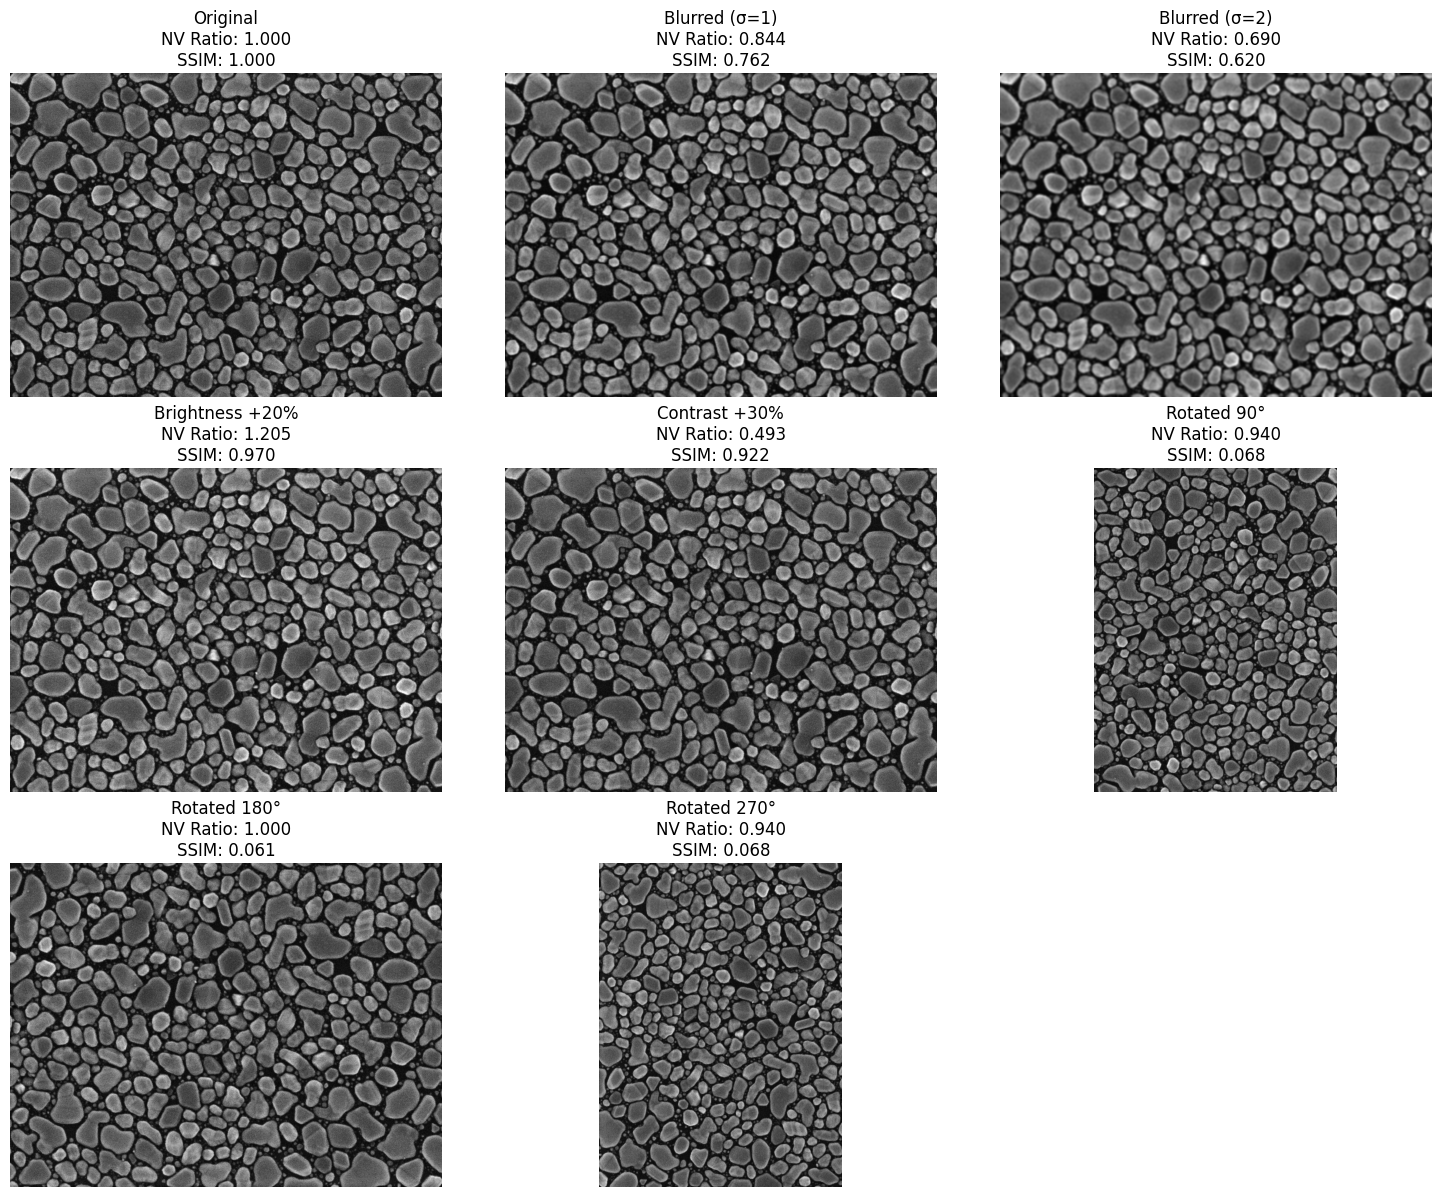

Metric Comparison Across Image Variations
Image Variation      NV Ratio   PSNR       SSIM      
------------------------------------------------------------------------------------------
Original             1.000      inf        1.000     
Blurred (σ=1)        0.844      27.361     0.762     
Blurred (σ=2)        0.690      24.378     0.620     
Brightness +20%      1.205      23.288     0.970     
Contrast +30%        0.493      25.854     0.922     
Rotated 90°          0.940      12.526     0.068     
Rotated 180°         1.000      12.361     0.061     
Rotated 270°         0.940      12.525     0.068     

KEY INSIGHTS:
1. Normalized Variance (NV) ratio remains relatively stable across
   brightness changes but decreases consistently with blur.
2. PSNR and SSIM are highly sensitive to brightness/contrast changes,
   which are common in SEM imaging but don't necessarily indicate focus quality.
3. NV is rotation-invariant, providing consistent scores for rotated images.
4. For Gold

In [9]:
# Generate results
results = create_focus_assessment_demo(GoC)
# insights
print("\n" + "="*90)
print("KEY INSIGHTS:")
print("="*90)
print("1. Normalized Variance (NV) ratio remains relatively stable across")
print("   brightness changes but decreases consistently with blur.")
print("2. PSNR and SSIM are highly sensitive to brightness/contrast changes,")
print("   which are common in SEM imaging but don't necessarily indicate focus quality.")
print("3. NV is rotation-invariant, providing consistent scores for rotated images.")
print("4. For Gold-on-Carbon SEM images, NV provides a more consistent focus measure")
print("   that aligns with human perception of sharpness.")

# Distortion types:
This section explores a couple of [different distortion types](https://doi.org/10.1016/j.image.2014.10.009) and apply test metrics (such as SSIM, PSNR, etc) to see the score produced by these methods. This would help a CD-SEM engineer to understand and compare between distorted and reference images. 

SEM like stigmation distortion function and Poisson_gaussian function were included to simulate stigmated and noisy image

**Distortion level 5 was used for the following noise types(1,3,4,7,8,17,19)**
- Type 1  : Additive Gaussian noise
- Type 3  : Spatially correlated noise
- Type 4  : Masked noise
- Type 7  : Quantization noise
- Type 8  : Gaussian blur
- Type 17 : Contrast change
- Type 19 : Multiplicative Gaussian noise
- Custom distortions:
    - apply SEM like stigmation
    - poisson_gaussian 

## Multiplicative Gaussian

Here multiplicative Gaussian noisy image(Type # 19) has been tested. Other types of noisy image can be selected from the `noisy_img_dict[noise type]` dictionary. For custom noise function(i.e., Poisson, and stigmation) please see below.

In [10]:
""" 
- reference image as original image
- "gaussian_multiplicative" noise type selected as distorted image 
  other noise types from the "noisy_img_dict[noise_type]" can
  be selected
"""
orig_image = load2gray(ref_image)
distorted_image = load2gray(noisy_img_dict["gaussian_multiplicative"])
metric_results = calculate_all_metrics(orig_image, distorted_image)

IMAGE QUALITY ASSESSMENT REPORT
Distortion Type: Multiplicative Gaussian

1. MAIN METRICS COMPARISON
--------------------------------------------------
+---------------------------+-----------------+---------------+-----------------------+
|          Metric           |  Current Value  |  Ideal Value  |    Interpretation     |
+===========================+=================+===============+=======================+
|           SSIM            |     0.7269      |    1.0000     |   Higher is better    |
+---------------------------+-----------------+---------------+-----------------------+
|           PSNR            |    24.65 dB     |     ∞ dB      |   Higher is better    |
+---------------------------+-----------------+---------------+-----------------------+
|    NormVar Focus Ratio    |      0.987      |     1.000     | Closer to 1 is better |
+---------------------------+-----------------+---------------+-----------------------+
| Laplacian Sharpness Ratio |      1.076      |     1.00

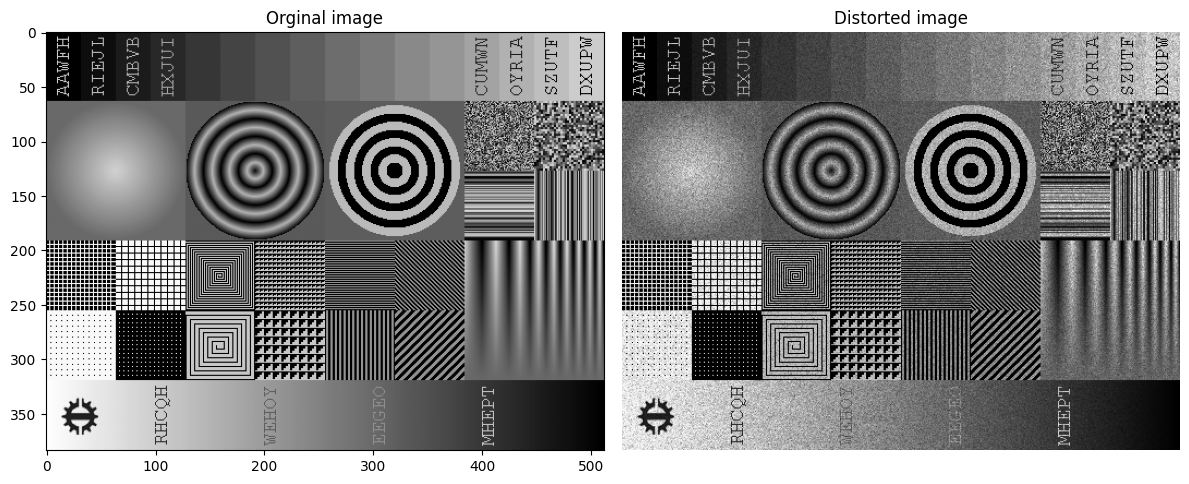

In [11]:
generate_quality_report(metric_results, distortion_name="Multiplicative Gaussian")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(orig_image,cmap="gray")
plt.title("Orginal image")

plt.subplot(1,2,2)
plt.imshow(distorted_image, cmap='gray')
plt.title("Distorted image")

plt.axis('off')
plt.tight_layout()
plt.show()

## Test on custom noise

Here we will apply two types of noises: 

1. Poisson_gaussian noise
2. stigmation 

We will test all the common metrics on these noise types.

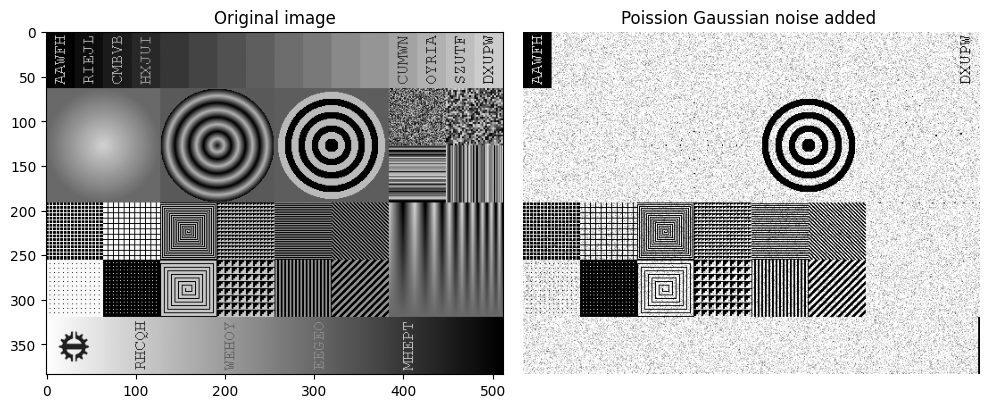

In [12]:
# simulating detector noise as much as possible
noisy_detector = add_poisson_gaussian(load2gray(ref_image), peak=20, read_std=0.002, gain=1.0, offset=0.0)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(orig_image,cmap='gray')
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(noisy_detector, cmap='gray')
plt.title("Poission Gaussian noise added ")

plt.axis('off')
plt.tight_layout()
plt.show()

## Poisson noise

**calculate test metrics**

In [14]:
poisson_metrics = calculate_all_metrics(orig_image, noisy_detector)

OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/filter.simd.hpp:3252: error: (-213:The function/feature is not implemented) Unsupported combination of source format (=5), and destination format (=6) in function 'getLinearFilter'



**generate report**

In [15]:
generate_quality_report(poisson_metrics, distortion_name="Poisson_Gaussian")

IMAGE QUALITY ASSESSMENT REPORT
Distortion Type: Poisson_Gaussian

1. MAIN METRICS COMPARISON
--------------------------------------------------
+---------------------------+-----------------+---------------+-----------------------+
|          Metric           |  Current Value  |  Ideal Value  |    Interpretation     |
+===========================+=================+===============+=======================+
|           SSIM            |     0.0000      |    1.0000     |   Higher is better    |
+---------------------------+-----------------+---------------+-----------------------+
|           PSNR            |     6.00 dB     |     ∞ dB      |   Higher is better    |
+---------------------------+-----------------+---------------+-----------------------+
|    NormVar Focus Ratio    |      0.003      |     1.000     | Closer to 1 is better |
+---------------------------+-----------------+---------------+-----------------------+
| Laplacian Sharpness Ratio |      0.000      |     1.000     |

## Stigmation

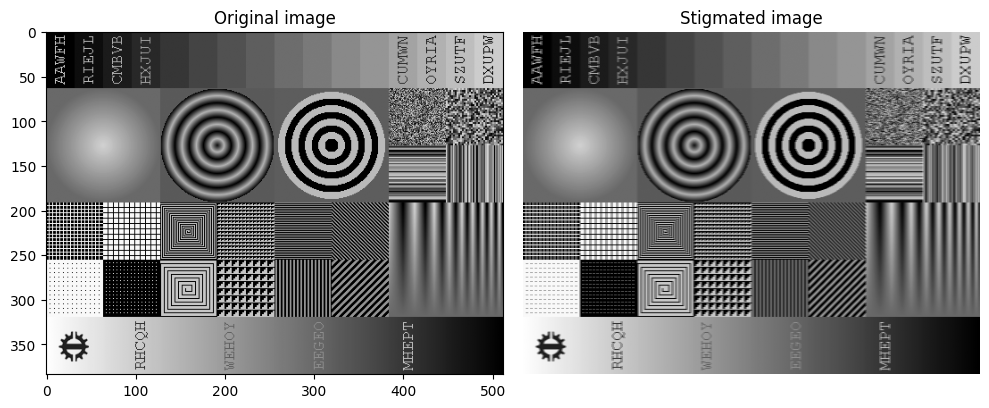

In [16]:
# mild stigmation
stigmated = apply_stigmation(load2gray(ref_image), ksize_x=3, ksize_y=1, angle=0.5)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(orig_image,cmap='gray')
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(stigmated, cmap='gray')
plt.title("Stigmated image")

plt.axis('off')
plt.tight_layout()
plt.show()

## Test metrics on Stigmated image 

In [17]:
stig_metrics = calculate_all_metrics(orig_image, stigmated)

In [18]:
generate_quality_report(stig_metrics, distortion_name="Stigmation")

IMAGE QUALITY ASSESSMENT REPORT
Distortion Type: Stigmation

1. MAIN METRICS COMPARISON
--------------------------------------------------
+---------------------------+-----------------+---------------+-----------------------+
|          Metric           |  Current Value  |  Ideal Value  |    Interpretation     |
+===========================+=================+===============+=======================+
|           SSIM            |     0.8497      |    1.0000     |   Higher is better    |
+---------------------------+-----------------+---------------+-----------------------+
|           PSNR            |    18.01 dB     |     ∞ dB      |   Higher is better    |
+---------------------------+-----------------+---------------+-----------------------+
|    NormVar Focus Ratio    |      0.773      |     1.000     | Closer to 1 is better |
+---------------------------+-----------------+---------------+-----------------------+
| Laplacian Sharpness Ratio |      0.382      |     1.000     | Close

## FFT sharpness

- Comparing sharpness using FFT( Fast Fourier Transform)
- Using SEM like stigmated image for FFT sharness

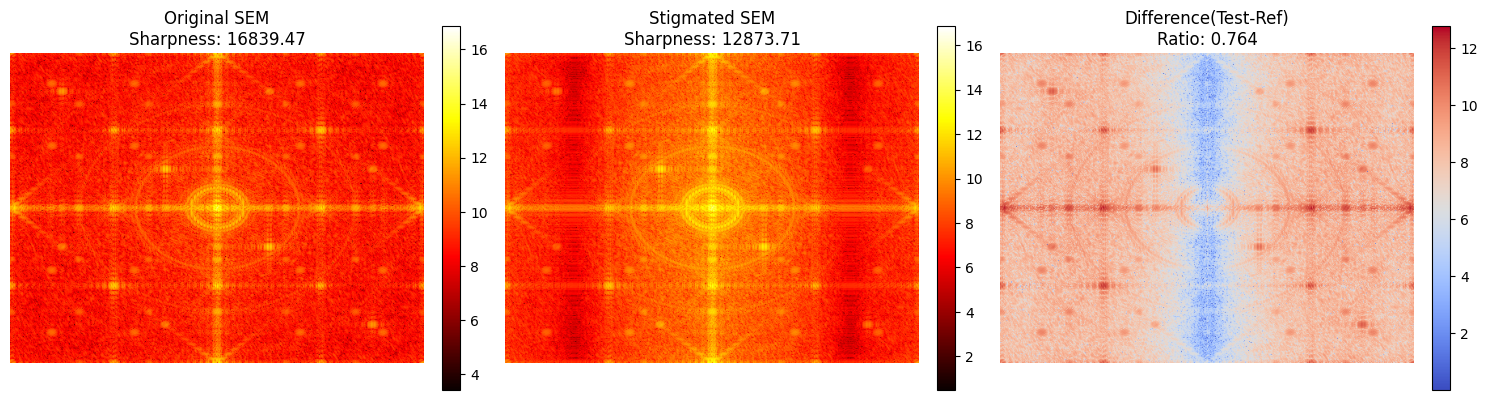

FFT SPECTRUM ANALYSIS REPORT
Reference Sharpness: 16839.47
Test Sharpness: 12873.71
Sharpness Ratio: 0.764
Sharpness Difference(Test-Ref): -3965.76
Assessment: ~ Moderate focus loss


In [19]:
fft_results = fft_sharpness_comparative(ref_image, stigmated)
plot_fft_comparison(fft_results, "Original SEM", "Stigmated SEM")

## Image Histogram 
Compare histogram for comparing tool matching 

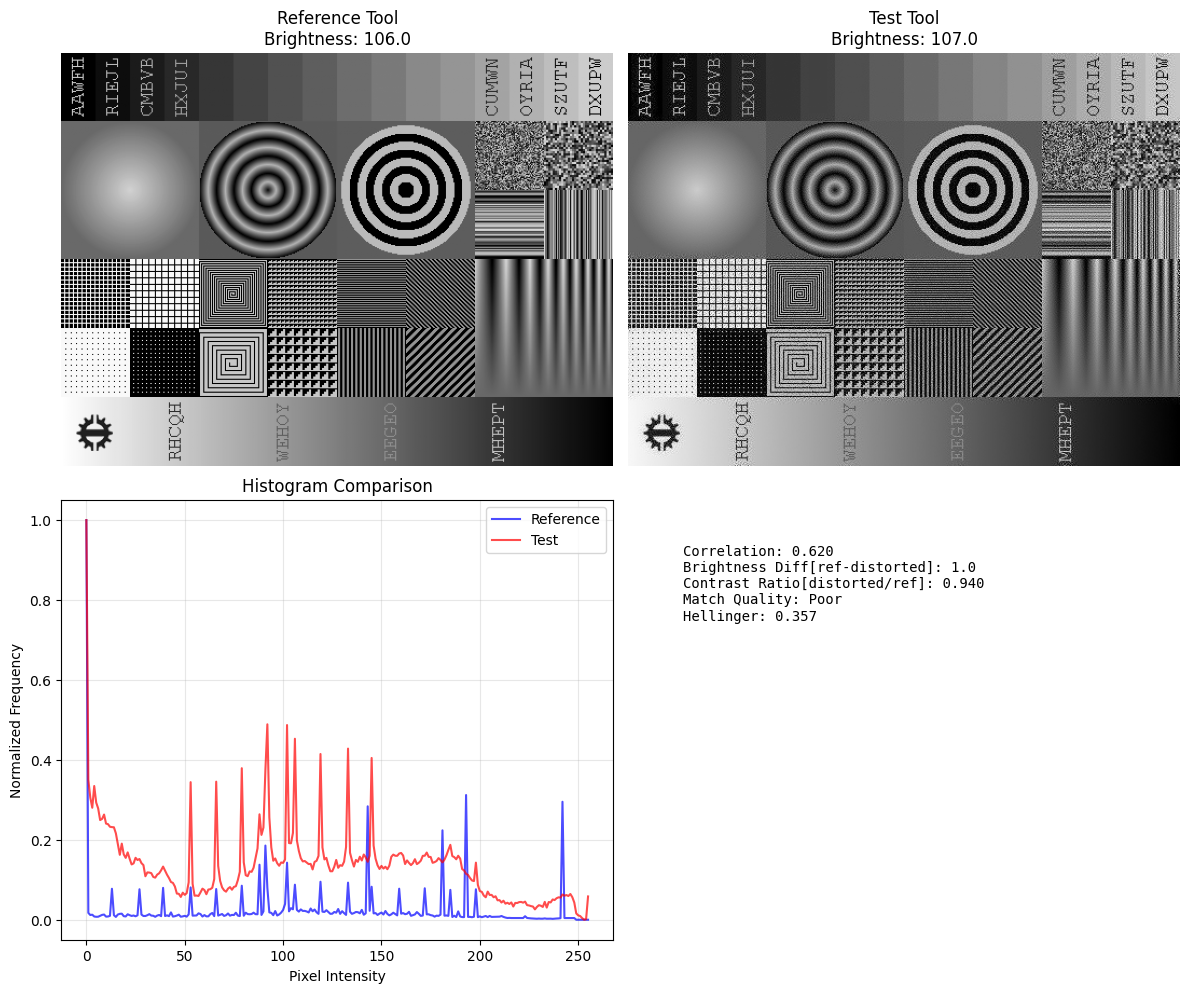

Histogram report
correlation_score : 0.619901880986867
chi_square : 323.4258824941811
hellinger_distance : 0.3573807033639551
intersection : 5.861334927380085
ref_brightness : 106.04271443684895
ref_contrast : 72.60911551047302
dis_brightness : 106.99887084960938
dis_contrast : 68.2165837441007
brightness_difference : 0.9561564127604214
contrast_ratio : 0.9395044033315797
dynamic_range_ref : 248
dynamic_range_dis : 255
match_quality : Poor


In [20]:

histogram_result = compare_histograms(orig_image, load2gray(noisy_img_dict["masked_noise"]), plot_histograms=True)
print("Histogram report")
print("=="*20)
for key , items in zip(histogram_result.keys(),histogram_result.items()):
    print(key, ":", items[1])
print("=="*20)

#load2gray(noisy_img_dict["gaussian_blur"])

# Conclusion

This notebook establishes a clear, reproducible basis for SEM image quality checks and tool-to-tool matching:

- Effective for common failure modes.

    - Focus/blur & stigmation: Laplacian and FFT-ratio trend down as blur increases; SSIM agrees and localizes loss on edges.

    - Noise (shot/read): SSIM/PSNR decline with higher noise; FFT-ratio can rise (noise injects high-frequency energy) while Laplacian stays relatively stable, helping distinguish noisy-sharp from clean-blurred.

    - Operating-point drift: Histogram means/widths and CNR reveal gain/offset and contrast changes that don’t always show up in sharpness scores.

- Actionable in production.
The metrics are quick to compute, easy to threshold, and simple to visualize on dashboards. They support spot checks, lot start/end health checks, and tool matching after maintenance or recipe edits.

- Auditable and transferable.
All steps are documented, with deterministic preprocessing (grayscale normalization, fixed ROIs, seeds). Because the methods are standard and lightweight, they are easy to adopt across teams and tools.

## Practical takeaways

- Use SSIM + Laplacian + FFT-ratio together: the trio separates blur from noise and flags structural loss where it matters (edges and features).

- Track histogram stats for day-to-day tool consistency and after any detector/beam parameter changes.

- When a flag triggers, inspect SSIM maps and FFT views to locate the problem (focus/stigmation/operating point).

## Acknowledgement

- [N. Ponomarenko, L. Jin, O. Ieremeiev, V. Lukin, K. Egiazarian, J. Astola, 
B. Vozel, K. Chehdi, M. Carli, F. Battisti, C.-C. Jay Kuo, 
Image database TID2013: Peculiarities, results and perspectives, 
Signal Processing: Image Communication, vol. 30, Jan. 2015, pp. 57-77.](https://doi.org/10.1016/j.image.2014.10.009)

- [Autofocusing algorithm selection in computer microscopy, Yu Sun; S. Duthaler; B.J. Nelson](https://doi.org/10.1002/jemt.20118)

